## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp(input_shape, output_units, num_neurons, drp_ratio):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.25, 0.5, 0.75]

In [10]:
def Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, Dropout_EXP, output_units, num_neurons, ch, results):
    for regulizer_ratio in Dropout_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
        model = build_mlp(x_train.shape[1:], output_units, num_neurons, regulizer_ratio)
        model.summary()
        # choise optimizer
        if ch == 1:
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        else:
            optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=None, decay=0.0)
            
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        
        exp_name_tag = "Dropout rate %s" % str(regulizer_ratio)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def Draw_Result(results, ch):
    color_bar = ["r", "g", "b", "y", "m", "k"]
    
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    
    sOptim = ""
    if ch ==1:
        sOptim = "SGD "
    else:
        sOptim = "Adam "
    
    plt.title(sOptim + "Loss")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()
        
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title(sOptim + "Accuracy")
    plt.legend()
    plt.show()

In [11]:
# 使用隱藏 3層, SGD, Dropout_EXP = [0.25, 0.5, 0.75]
output_units = 10
num_neurons_1 = [512, 256, 128]

results_sgd = {}
Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, Dropout_EXP, output_units, num_neurons_1, 1, results_sgd)

Experiment with Regulizer = 0.250000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128

50000/50000 [==============================] - 5s 94us/step - loss: 1.2984 - acc: 0.5362 - val_loss: 1.3063 - val_acc: 0.5350
Epoch 50/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.2816 - acc: 0.5428 - val_loss: 1.3044 - val_acc: 0.5334
Experiment with Regulizer = 0.500000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256

Epoch 48/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.6020 - acc: 0.4283 - val_loss: 1.4762 - val_acc: 0.4693
Epoch 49/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.5921 - acc: 0.4333 - val_loss: 1.4731 - val_acc: 0.4761
Epoch 50/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.5889 - acc: 0.4321 - val_loss: 1.4816 - val_acc: 0.4712


W0718 21:15:42.449114 18700 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0718 21:15:42.476043 18700 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0718 21:15:42.497984 18700 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Experiment with Regulizer = 0.750000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128

50000/50000 [==============================] - 5s 97us/step - loss: 2.0488 - acc: 0.2015 - val_loss: 2.1695 - val_acc: 0.1645
Epoch 50/50
50000/50000 [==============================] - 5s 97us/step - loss: 2.0496 - acc: 0.2039 - val_loss: 2.1692 - val_acc: 0.1625


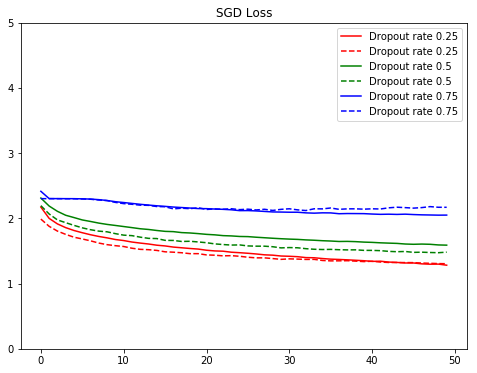

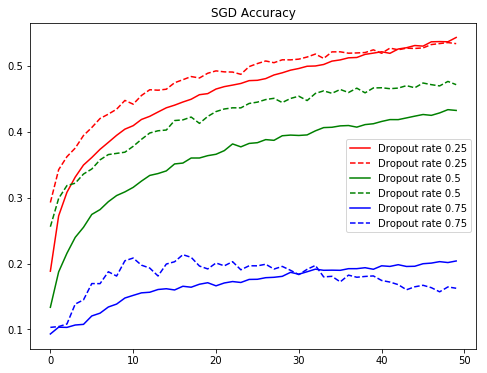

In [14]:
Draw_Result(results_sgd, 1)

In [15]:
# 使用隱藏 5層, SGD, Dropout_EXP = [0.25, 0.5, 0.75]
output_units = 10
num_neurons_2 = [512, 256, 128, 64, 32]

results_Adam = {}
Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, Dropout_EXP, output_units, num_neurons_2, 2, results_Adam)

Experiment with Regulizer = 0.250000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128

50000/50000 [==============================] - 6s 122us/step - loss: 1.7032 - acc: 0.3904 - val_loss: 1.6373 - val_acc: 0.4251
Epoch 46/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.6937 - acc: 0.3889 - val_loss: 1.6293 - val_acc: 0.4182
Epoch 47/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.7032 - acc: 0.3890 - val_loss: 1.6261 - val_acc: 0.4191
Epoch 48/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.7026 - acc: 0.3893 - val_loss: 1.6407 - val_acc: 0.4233
Epoch 49/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.6896 - acc: 0.3937 - val_loss: 1.6279 - val_acc: 0.4247
Epoch 50/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.6955 - acc: 0.3913 - val_loss: 1.6128 - val_acc: 0.4248
Experiment with Regulizer = 0.500000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (

50000/50000 [==============================] - 6s 121us/step - loss: 2.1234 - acc: 0.1659 - val_loss: 2.2331 - val_acc: 0.1282
Epoch 40/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.1206 - acc: 0.1706 - val_loss: 2.2262 - val_acc: 0.1305
Epoch 41/50
50000/50000 [==============================] - 6s 120us/step - loss: 2.1218 - acc: 0.1676 - val_loss: 2.2386 - val_acc: 0.1278
Epoch 42/50
50000/50000 [==============================] - 6s 120us/step - loss: 2.1198 - acc: 0.1681 - val_loss: 2.2516 - val_acc: 0.1206
Epoch 43/50
50000/50000 [==============================] - 6s 120us/step - loss: 2.1208 - acc: 0.1701 - val_loss: 2.2274 - val_acc: 0.1353
Epoch 44/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.1224 - acc: 0.1705 - val_loss: 2.2524 - val_acc: 0.1201
Epoch 45/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.1208 - acc: 0.1701 - val_loss: 2.2359 - val_acc: 0.1231
Epoch 46/50
50000/50000 [==============

W0718 21:44:54.205391 18700 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0718 21:44:54.223343 18700 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Experiment with Regulizer = 0.750000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128

50000/50000 [==============================] - 6s 123us/step - loss: 2.3027 - acc: 0.0980 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 46/50
50000/50000 [==============================] - 6s 123us/step - loss: 2.3027 - acc: 0.0986 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 47/50
50000/50000 [==============================] - 6s 123us/step - loss: 2.3027 - acc: 0.0978 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 6s 123us/step - loss: 2.3027 - acc: 0.0976 - val_loss: 2.3026 - val_acc: 0.1000 - 
Epoch 49/50
50000/50000 [==============================] - 6s 123us/step - loss: 2.3027 - acc: 0.0979 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.3027 - acc: 0.0971 - val_loss: 2.3026 - val_acc: 0.1000


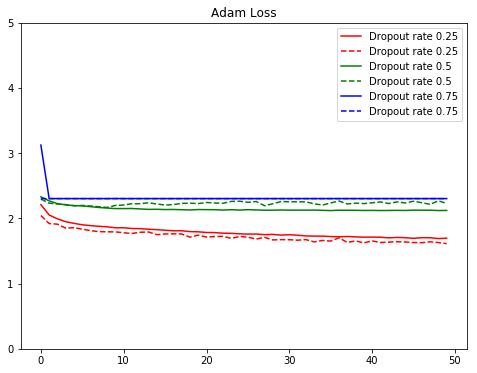

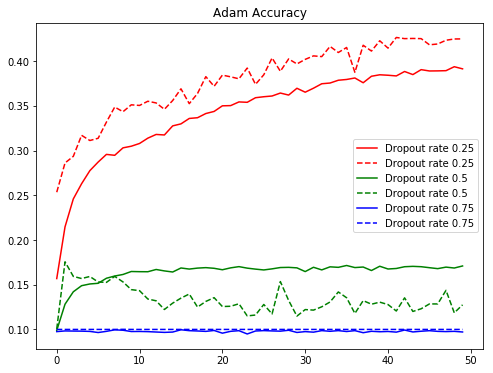

In [16]:
Draw_Result(results_Adam, 2)